In [1]:
import argparse
from tqdm import tqdm

import faiss
import torch
import torch.nn.functional as F
import clip
import numpy as np
import os
import shutil

from react_retrieval.utils.prompts import *
from react_retrieval.data.filelist_controller import FileListController

from autofaiss.utils.decorators import Timeit

import logging


def setup_logging(logging_level: int):
    """Setup the logging."""
    logging.config.dictConfig(dict(version=1, disable_existing_loggers=False))
    logging_format = "%(asctime)s [%(levelname)s]: %(message)s"
    logging.basicConfig(level=logging_level, format=logging_format)

/home/aiscuser/.conda/envs/react/lib/python3.7/site-packages/clip/clip.py:24: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [14]:
from IPython.display import Image as IPImage
from IPython.display import display
from PIL import Image

In [3]:
def get_argument_parser():
    parser = argparse.ArgumentParser(description='Extract features from Vision-Language datasets.')
    parser.add_argument('--model', type=str, default='vitb32')
    parser.add_argument('--metafile', type=str)
    parser.add_argument('--scatter_dir', type=str)
    parser.add_argument('--faiss_index', type=str)
    parser.add_argument('--output_dir', type=str)
    parser.add_argument('--dataset', type=str, help='ICinW dataset name.')
    parser.add_argument('--images_per_class', type=int, default=50, help='number of images per class')
    return parser

In [4]:
args = get_argument_parser().parse_args([
    "--metafile", "../data/laion-400m/processed/filelist.pkl",
    "--scatter_dir", "../data/laion-400m/scattered",
    "--faiss_index", "../data/laion-400m/processed/image.index",
    "--output_dir", "../data/laion-400m/retrieval",
    "--dataset", "caltech-101",
    "--images_per_class", "200",
])

setup_logging(logging.INFO)

In [5]:
with Timeit(f"Loading index: {args.faiss_index}"):
    index = faiss.read_index(args.faiss_index)

2023-02-24 02:56:35,656 [INFO]: Loading index: ../data/laion-400m/processed/image.index 02/24/2023, 02:56:35
2023-02-24 02:58:33,793 [INFO]: >>> Finished "Loading index: ../data/laion-400m/processed/image.index" in 118.1357 secs


In [6]:
with Timeit(f"Loading file list controller: {args.metafile}"):
    file_list_controller = FileListController(args.metafile, args.scatter_dir)

2023-02-24 02:58:33,805 [INFO]: Loading file list controller: ../data/laion-400m/processed/filelist.pkl 02/24/2023, 02:58:33
2023-02-24 03:00:05,829 [INFO]: >>> Finished "Loading file list controller: ../data/laion-400m/processed/filelist.pkl" in 92.0231 secs


In [7]:
class_names = class_map[args.dataset]
templates = template_map[args.dataset]

model_name = {
    "vitb32": "ViT-B/32",
    "vitb16": "ViT-B/16",
    "vitl14": "ViT-L/14",
}[args.model]

with Timeit(f"Loading model: {model_name}"):
    if model_name in clip.available_models():
        model, preprocess = clip.load(model_name)
    model.cuda().eval()

2023-02-24 03:00:15,449 [INFO]: Loading model: ViT-B/32 02/24/2023, 03:00:15
2023-02-24 03:00:45,799 [INFO]: >>> Finished "Loading model: ViT-B/32" in 30.3486 secs


In [8]:
def query_by_text(texts, model, index, k):
    assert type(texts) is list, "Please wrap texts into List[str]."

    texts = clip.tokenize(texts, context_length=77, truncate=True).cuda()
    with torch.no_grad():
        text_embeddings = model.encode_text(texts)
        text_embeddings = F.normalize(text_embeddings)

    queries = text_embeddings.data.cpu().numpy().astype('float32')
    dists, knns = index.search(queries, k)
    
    return dists, knns

dists, knns = query_by_text(['a professional photo of a dog'], model, index, k=args.images_per_class)

purebred golden retriever sitting in front of a white background


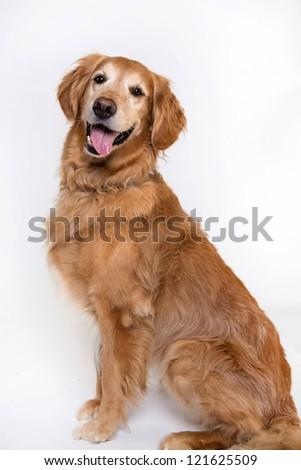

In [15]:
image_file, text_file = file_list_controller[knns[0, 8]]
image = IPImage(filename=image_file)
print(open(text_file, 'r').read())
display(image)

In [103]:
def collect_retrieved_images(knns, output_dir):
    for idx in range(knns.shape[0]):
        subdir = os.path.join(output_dir, f'{idx:03d}')
        os.makedirs(subdir, exist_ok=True)
        for knn_idx in knns[idx]:
            image_file, text_file = file_list_controller[knn_idx]
            shutil.copy2(image_file, os.path.join(subdir, os.path.basename(image_file)))
            shutil.copy2(text_file, os.path.join(subdir, os.path.basename(text_file)))

collect_retrieved_images(knns, output_dir=os.path.join(args.output_dir, args.dataset, f'{args.images_per_class}nn', 'dog'))

# I2I retrieval

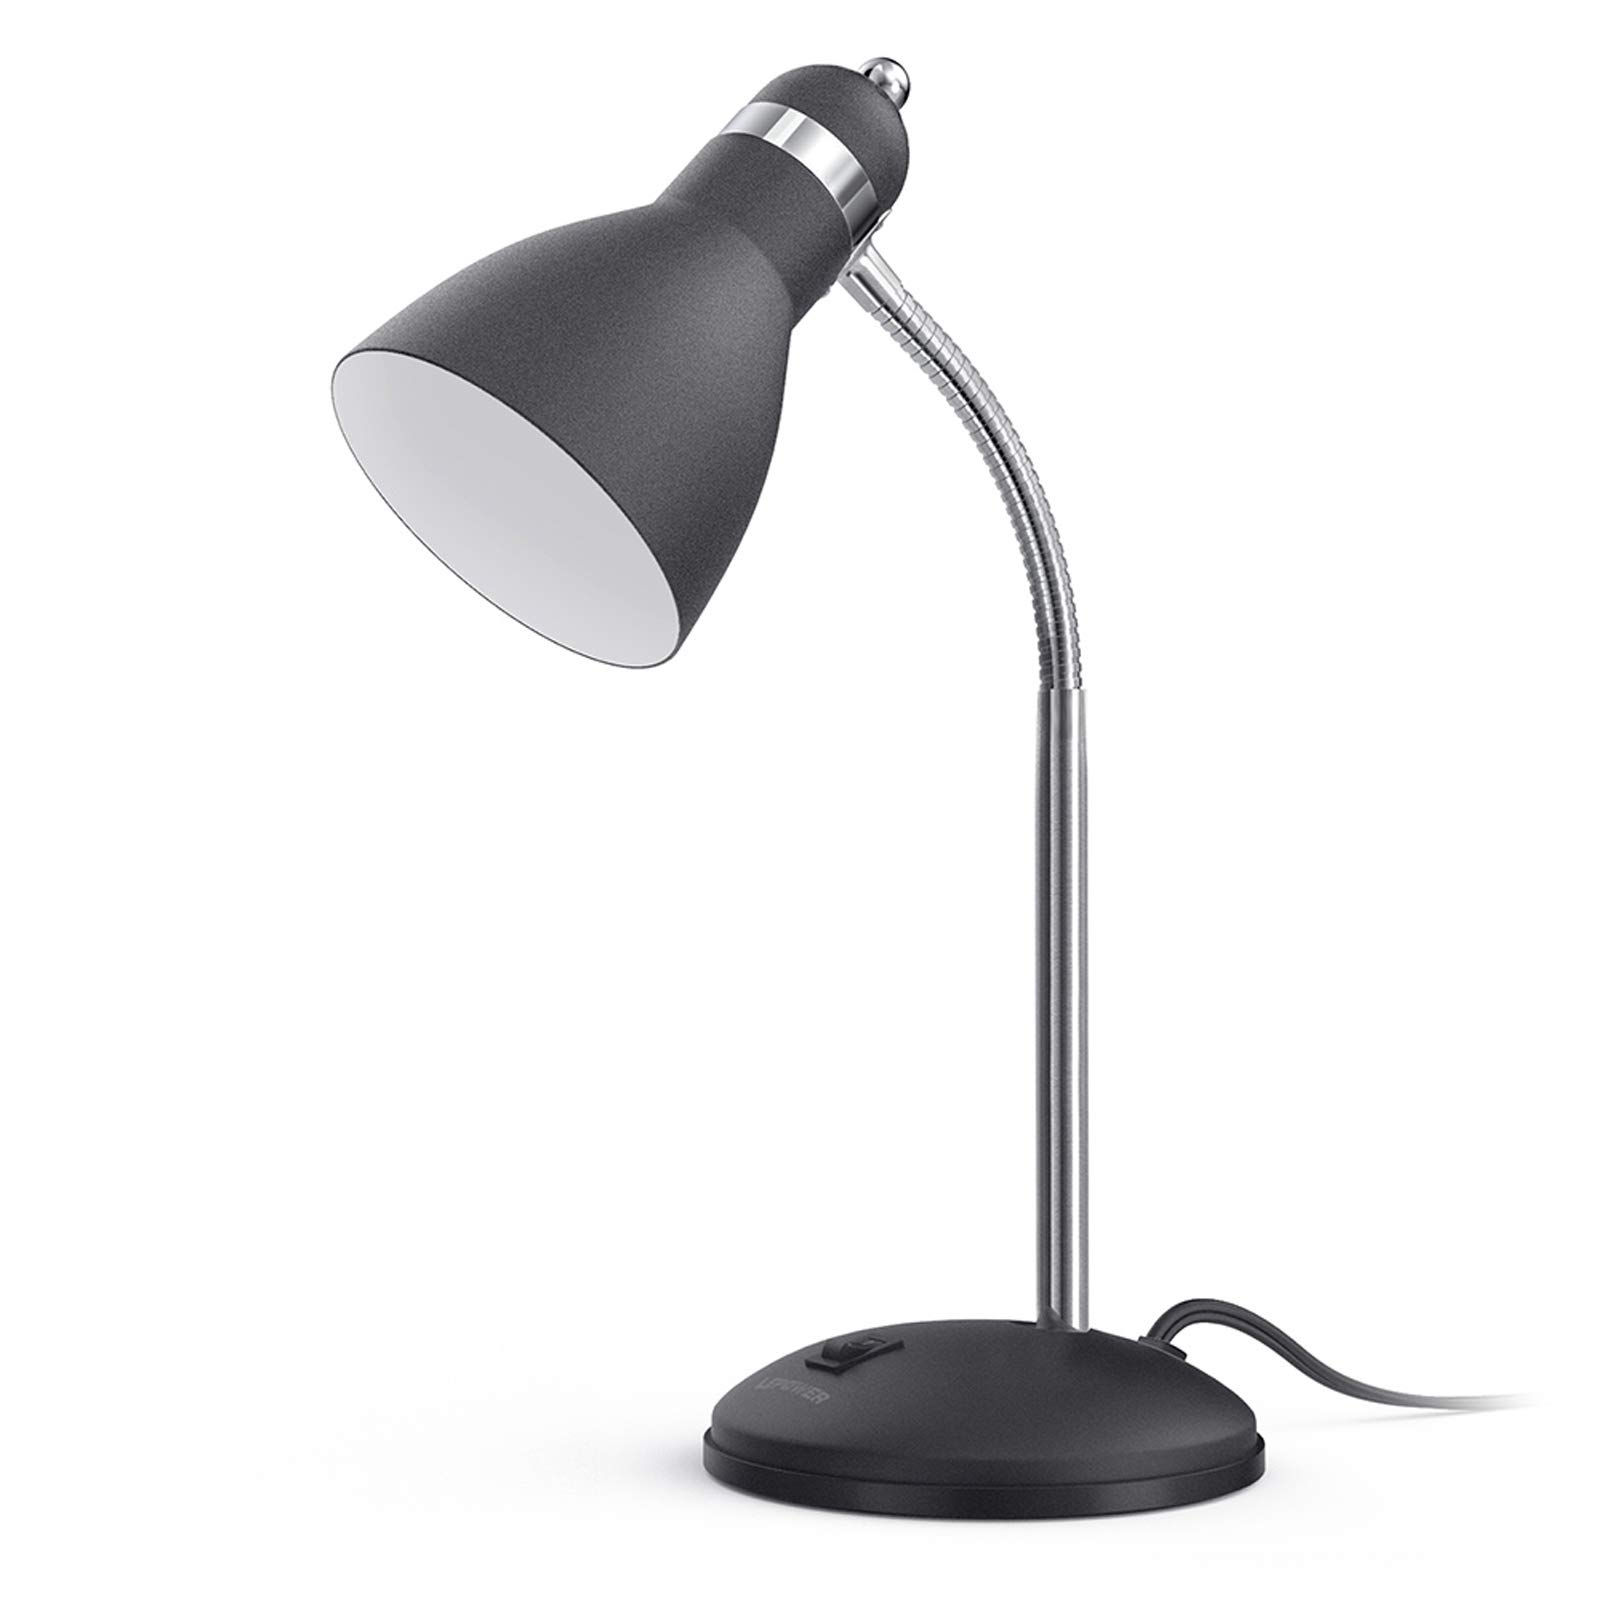

LEPOWER Metal Desk Lamp, Eye-Caring Table Lamp, Study Lamps with Flexible Goose Neck for Bedroom and Office ( Sandy Black)


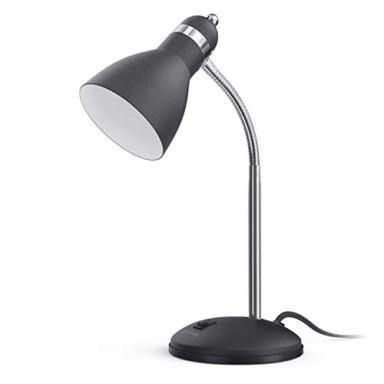

In [18]:
def retrieve_i2i(image_file, k=1):
    image = Image.open(image_file)
    display(IPImage(filename=image_file))
    
    image = preprocess(image).cuda().unsqueeze(0)
    image_embeddings = model.encode_image(image)
    image_embeddings = F.normalize(image_embeddings)

    queries = image_embeddings.data.cpu().numpy().astype('float32')
    dists, knns = index.search(queries, k)

    image_file, text_file = file_list_controller[knns[0, 0]]
    image = IPImage(filename=image_file)
    print(open(text_file, 'r').read())
    display(image)

retrieve_i2i('./src_images/lamp.jpg')